# Análise Comparativa de Modelos Word2Vec em Tarefas de Representação Semântica e Sintática

## Introdução

O trabalho proposto tem como objetivo explorar a aplicação de modelos de representação vetorial de palavras, particularmente os modelos Skip-Gram e Continuous Bag of Words (CBOW), para capturar relações semânticas e sintáticas entre palavras em um corpus de texto. A implementação visa avaliar o desempenho desses modelos em tarefas como avaliação de analogias de palavras, precisão por categoria e análise de similaridade entre pares de palavras.

## Problema

A representação de palavras é uma parte crucial do processamento de linguagem natural (PLN). Os modelos Word2Vec, como Skip-Gram e CBOW, visam criar representações vetoriais eficazes para palavras, permitindo que o modelo capture relações semânticas e sintáticas. Essas representações são valiosas para várias aplicações, incluindo recuperação de informações, tradução automática e agrupamento semântico.

## Importação de Bibliotecas

In [67]:
import requests
import zipfile
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from sklearn.manifold import TSNE
from spacy.lang.en.stop_words import STOP_WORDS
from itertools import product
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from sklearn.manifold import TSNE
from multiprocessing import cpu_count

## Importação de Corpus e Arquivo de Analogia

In [2]:
zip_url = "http://mattmahoney.net/dc/text8.zip"
zip_filename = "text8.zip"

response = requests.get(zip_url, stream=True)
with open(zip_filename, 'wb') as zip_file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            zip_file.write(chunk)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("")

os.remove(zip_filename)
#https://drive.google.com/file/d/1x135MMFd5dq-27QCFJXHUUKbOBGBLWFf/view?usp=sharing
!gdown --id "1x135MMFd5dq-27QCFJXHUUKbOBGBLWFf"

/home/mcatrinque/.local/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1x135MMFd5dq-27QCFJXHUUKbOBGBLWFf
To: /home/mcatrinque/Documentos/NLP/tp1/questions-words.txt
100%|████████████████████████████████████████| 604k/604k [00:00<00:00, 1.87MB/s]


## Modelos: Skip-Gram e CBOW

* Skip-Gram: Este modelo visa prever as palavras de contexto (vizinhas) dada uma palavra de destino. É particularmente eficaz na captura de relações semânticas entre palavras.

* CBOW: Em oposição ao Skip-Gram, o CBOW prevê a palavra de destino a partir de um contexto (vizinhança) conhecido. Este modelo é eficaz em capturar a estrutura sintática das palavras.

## Escolha dos Modelos

A escolha entre Skip-Gram e CBOW depende do contexto da aplicação. O Skip-Gram tende a funcionar bem em conjuntos de dados grandes, capturando nuances semânticas, enquanto o CBOW pode ser mais eficiente em conjuntos de dados menores, capturando relações sintáticas.

## Treinamento do Modelo Word2Vec

O treinamento do modelo Word2Vec é realizado considerando diferentes combinações de hiperparâmetros, a fim de explorar o impacto de cada um na qualidade dos vetores de palavras resultantes. Abaixo, apresentamos uma explicação detalhada de cada hiperparâmetro explorado:

1. **Dimensão do Vetor (vector_dim):** O tamanho dos vetores de palavras resultantes. Valores maiores podem capturar relações mais complexas, mas exigem mais dados e poder computacional.

2. **Tamanho da Janela de Contexto (context_window_size):** O número de palavras ao redor da palavra-alvo considerado durante o treinamento. Uma janela maior permite capturar contextos mais amplos.

3. **Limiar de Downsampling (downsampling_threshold):** Controla a taxa de downsampling de palavras frequentes. Valores menores reduzem o impacto de palavras frequentes.

4. **Número de Threads (num_threads):** Número de threads a serem usadas durante o treinamento. Aumentar pode acelerar o processo em máquinas com vários núcleos.

5. **Formato de Saída (output_format):** Pode ser 'text' ou 'binary', definindo se o modelo deve ser salvo em formato de texto ou binário.

6. **Épocas de Treinamento (epochs):** O número de iterações sobre o conjunto de dados durante o treinamento. Mais épocas podem melhorar a qualidade, mas aumentam o tempo de treinamento.

7. **Hierarchical Softmax (hs):** Se 1, usa o softmax hierárquico no treinamento; se 0, usa o softmax negativo. O softmax hierárquico é eficiente para grandes vocabulários.

8. **Amostragem Negativa (negative):** Número de palavras "negativas" a serem amostradas durante o treinamento. Valores mais altos podem melhorar a qualidade dos vetores.

9. **Contagem Mínima (min_count):** Ignora palavras com contagem total inferior a esse valor. Isso ajuda a remover palavras raras que podem não ter representações significativas.

Esses hiperparâmetros foram explorados em combinação para treinar modelos Skip-Gram e CBOW, e a avaliação de desempenho foi realizada em termos de acurácia em analogias de palavras, precisão por categoria e média da similaridade de cosseno entre pares de palavras. A escolha dos melhores modelos considerou a maximização dessas métricas.


In [3]:
def train_word2vec_model(corpus_path, vector_dim, context_window_size, downsampling_threshold, num_threads, output_format, epochs, hs, negative, min_count):
    # Verifica se hs e negative são mutuamente exclusivos
    if hs == 1:
        negative = 0
    # Carrega as sentenças do corpus
    sentences = LineSentence(corpus_path)
    
    # Configuração do modelo Word2Vec
    model = Word2Vec(
        sentences=sentences,
        vector_size=vector_dim,
        window=context_window_size,
        sg=True,  # Sempre usando skip-gram (pode ser configurado conforme necessário)
        hs=hs,
        negative=negative,
        sample=downsampling_threshold,
        workers=num_threads,
        epochs=epochs,
        min_count=min_count
    )

    # Caminho para salvar o modelo
    output_model_path = f"word2vec_model_dim{vector_dim}_win{context_window_size}_hs{hs}_neg{negative}_mincount{min_count}.{output_format}"
    
    # Treinamento do modelo com tqdm para acompanhar o progresso
    for _ in tqdm(range(epochs), desc=f'Training Word2Vec (dim={vector_dim}, win={context_window_size}, hs={hs}, neg={negative}, min_count={min_count})'):
        model.train(sentences, total_examples=model.corpus_count, epochs=1)
        
    # Salva o modelo treinado
    model.save(output_model_path)
    
    return model

In [5]:
hyperparameters = {
    'vector_dim': [50, 100],                 # Tamanhos diferentes para a dimensão do vetor
    'context_window_size': [3, 5],           # Tamanhos diferentes para a janela de contexto
    'downsampling_threshold': [1e-3],  # Diferentes valores para o limiar de downsampling
    'num_threads': [cpu_count()],         # Diferentes números de threads (usando cpu_count para usar todos os núcleos disponíveis)
    'output_format': ['text'],               # Formato de saída 
    'epochs': [5, 10],                       # Números diferentes de épocas de treinamento
    'hs': [0, 1],                            # Hierarchical Softmax: 0 para negativo sampling, 1 para Hierarchical Softmax
    'negative': [5],                     # Número de amostras negativas para treinamento
    'min_count': [5]                      # Contagem mínima de palavras para considerar no vocabulário
}


corpus_path = 'text8'
analogy_file = 'questions-words.txt'

In [6]:
# Treinamento do modelo Skip-Gram
skipgram_results = []
for params in product(*hyperparameters.values()):
    param_dict = dict(zip(hyperparameters.keys(), params))
    model = train_word2vec_model(corpus_path, **param_dict)
    skipgram_results.append((param_dict, model))

Training Word2Vec (dim=50, win=3, hs=0, neg=5, min_count=5): 100%|█| 5/5 [01:03<
Training Word2Vec (dim=50, win=3, hs=1, neg=0, min_count=5): 100%|█| 5/5 [01:25<
Training Word2Vec (dim=50, win=3, hs=0, neg=5, min_count=5): 100%|█| 10/10 [02:1
Training Word2Vec (dim=50, win=3, hs=1, neg=0, min_count=5): 100%|█| 10/10 [03:0
Training Word2Vec (dim=50, win=5, hs=0, neg=5, min_count=5): 100%|█| 5/5 [01:40<
Training Word2Vec (dim=50, win=5, hs=1, neg=0, min_count=5): 100%|█| 5/5 [01:58<
Training Word2Vec (dim=50, win=5, hs=0, neg=5, min_count=5): 100%|█| 10/10 [03:0
Training Word2Vec (dim=50, win=5, hs=1, neg=0, min_count=5): 100%|█| 10/10 [03:5
Training Word2Vec (dim=100, win=3, hs=0, neg=5, min_count=5): 100%|█| 5/5 [01:01
Training Word2Vec (dim=100, win=3, hs=1, neg=0, min_count=5): 100%|█| 5/5 [01:14
Training Word2Vec (dim=100, win=3, hs=0, neg=5, min_count=5): 100%|█| 10/10 [02:
Training Word2Vec (dim=100, win=3, hs=1, neg=0, min_count=5): 100%|█| 10/10 [02:
Training Word2Vec (dim=100, 

In [7]:
# Treinamento do modelo CBOW
cbow_results = []
for params in product(*hyperparameters.values()):
    param_dict = dict(zip(hyperparameters.keys(), params))
    model = train_word2vec_model(corpus_path, **param_dict)
    cbow_results.append((param_dict, model))

Training Word2Vec (dim=50, win=3, hs=0, neg=5, min_count=5): 100%|█| 5/5 [01:04<
Training Word2Vec (dim=50, win=3, hs=1, neg=0, min_count=5): 100%|█| 5/5 [01:24<
Training Word2Vec (dim=50, win=3, hs=0, neg=5, min_count=5): 100%|█| 10/10 [02:0
Training Word2Vec (dim=50, win=3, hs=1, neg=0, min_count=5): 100%|█| 10/10 [02:4
Training Word2Vec (dim=50, win=5, hs=0, neg=5, min_count=5): 100%|█| 5/5 [01:31<
Training Word2Vec (dim=50, win=5, hs=1, neg=0, min_count=5): 100%|█| 5/5 [01:57<
Training Word2Vec (dim=50, win=5, hs=0, neg=5, min_count=5): 100%|█| 10/10 [03:0
Training Word2Vec (dim=50, win=5, hs=1, neg=0, min_count=5): 100%|█| 10/10 [03:5
Training Word2Vec (dim=100, win=3, hs=0, neg=5, min_count=5): 100%|█| 5/5 [01:06
Training Word2Vec (dim=100, win=3, hs=1, neg=0, min_count=5): 100%|█| 5/5 [01:19
Training Word2Vec (dim=100, win=3, hs=0, neg=5, min_count=5): 100%|█| 10/10 [02:
Training Word2Vec (dim=100, win=3, hs=1, neg=0, min_count=5): 100%|█| 10/10 [02:
Training Word2Vec (dim=100, 

## Avaliação do Modelo

A avaliação do desempenho do modelo foi realizada utilizando três métricas principais:

* **Avaliação de Analogias de Palavras (Métrica 1):** Mede a capacidade do modelo de encontrar relações semânticas entre palavras.

* **Precisão de Analogias por Categoria (Métrica 2):** Avalia a capacidade do modelo em categorias específicas, oferecendo insights sobre seu desempenho em diferentes tipos de relações.

* **Similaridade de Cosseno entre Vetores (Métrica 3):** Calcula a média da similaridade de cosseno entre pares de palavras específicas, proporcionando uma visão geral da qualidade das representações vetoriais.

Essas métricas fornecem uma compreensão abrangente do desempenho dos modelos em diferentes aspectos semânticos e sintáticos.

### Visualização t-SNE

Além das métricas mencionadas acima, uma visualização t-SNE foi utilizada para oferecer uma representação gráfica das relações semânticas entre as palavras. O t-SNE (t-distributed Stochastic Neighbor Embedding) é uma técnica de redução de dimensionalidade que mapeia as similaridades entre pontos de dados de alta dimensão para um espaço bidimensional. Neste contexto, o t-SNE nos permite visualizar a proximidade de palavras no espaço vetorial, proporcionando insights adicionais sobre a qualidade das representações aprendidas pelo modelo.


In [38]:
def evaluate_word2vec_model(model, analogy_file, model_name, params):
    # Métrica 1: Avaliação de Analogias de Palavras
    accuracy, correct_answers = model.wv.evaluate_word_analogies(analogy_file)

    section1_correct = sum([len(category['correct']) for category in correct_answers if category['section'] == 'section1'])
    section1_total = sum([len(category['correct']) + len(category['incorrect']) for category in correct_answers if category['section'] == 'section1'])

    accuracy_section1 = section1_correct / section1_total if section1_total > 0 else 0

    # Métrica 2: Precisão de Analogias por Categoria
    category_accuracies = {}
    for category in correct_answers:
        category_name = category['section']
        category_correct = len(category['correct'])
        category_total = len(category['correct']) + len(category['incorrect'])
        category_accuracy = category_correct / category_total if category_total > 0 else 0
        category_accuracies[category_name] = category_accuracy

    # Métrica 3: Similaridade de Cosseno entre Vetores (média para pares de palavras)
    word_pairs = [('king', 'queen'), ('man', 'woman'), ('dog', 'cat')]  # Adicione mais pares conforme necessário
    cosine_similarities = [model.wv.similarity(word1, word2) for word1, word2 in word_pairs]
    average_cosine_similarity = np.mean(cosine_similarities)

    # Visualização 2D usando t-SNE
    reference_words = ['king', 'queen', 'man', 'woman', 'dog', 'cat']
    top_n = 20  # Número de palavras mais relevantes a serem exibidas

    # Calcula a média das similaridades de cosseno entre cada palavra e as palavras de referência
    similarities = np.array([[model.wv.similarity(word, ref_word) for ref_word in reference_words] for word in model.wv.index_to_key])
    average_similarities = np.mean(similarities, axis=1)

    # Seleciona as top N palavras mais relevantes
    top_words_indices = np.argsort(average_similarities)[-top_n:]
    words_for_tsne = [model.wv.index_to_key[idx] for idx in top_words_indices]
    vectors_for_tsne = np.array([model.wv[word] for word in words_for_tsne])

    tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # Ajuste a perplexidade conforme necessário
    vectors_2d = tsne.fit_transform(vectors_for_tsne)

    df = pd.DataFrame({'Word': words_for_tsne, 'X': vectors_2d[:, 0], 'Y': vectors_2d[:, 1]})

    # Avaliação dos resultados
    evaluation_results = {
        "accuracy_section1": accuracy_section1,
        "category_accuracies": category_accuracies,
        "average_cosine_similarity": average_cosine_similarity,
        "tsne_df": df
    }

    return evaluation_results

In [14]:
# Avaliação dos modelos skipgram
skipgram_evaluation_results = []
for params, model in skipgram_results:
    print(f"\nAvaliação do modelo Skip-Gram com hiperparâmetros: {params}")
    evaluation_result = evaluate_word2vec_model(model, analogy_file, 'Skip-Gram', params)
    skipgram_evaluation_results.append(evaluation_result)


Avaliação do modelo Skip-Gram com hiperparâmetros: {'vector_dim': 50, 'context_window_size': 3, 'downsampling_threshold': 0.001, 'num_threads': 8, 'output_format': 'text', 'epochs': 5, 'hs': 0, 'negative': 5, 'min_count': 5}

Avaliação do modelo Skip-Gram com hiperparâmetros: {'vector_dim': 50, 'context_window_size': 3, 'downsampling_threshold': 0.001, 'num_threads': 8, 'output_format': 'text', 'epochs': 5, 'hs': 1, 'negative': 5, 'min_count': 5}

Avaliação do modelo Skip-Gram com hiperparâmetros: {'vector_dim': 50, 'context_window_size': 3, 'downsampling_threshold': 0.001, 'num_threads': 8, 'output_format': 'text', 'epochs': 10, 'hs': 0, 'negative': 5, 'min_count': 5}

Avaliação do modelo Skip-Gram com hiperparâmetros: {'vector_dim': 50, 'context_window_size': 3, 'downsampling_threshold': 0.001, 'num_threads': 8, 'output_format': 'text', 'epochs': 10, 'hs': 1, 'negative': 5, 'min_count': 5}

Avaliação do modelo Skip-Gram com hiperparâmetros: {'vector_dim': 50, 'context_window_size': 

In [15]:
# Avaliação dos modelos CBOW
cbow_evaluation_results = []
for params, model in cbow_results:
    print(f"\nAvaliação do modelo CBOW com hiperparâmetros: {params}")
    evaluation_result = evaluate_word2vec_model(model, analogy_file, 'CBOW', params)
    cbow_evaluation_results.append(evaluation_result)


Avaliação do modelo CBOW com hiperparâmetros: {'vector_dim': 50, 'context_window_size': 3, 'downsampling_threshold': 0.001, 'num_threads': 8, 'output_format': 'text', 'epochs': 5, 'hs': 0, 'negative': 5, 'min_count': 5}

Avaliação do modelo CBOW com hiperparâmetros: {'vector_dim': 50, 'context_window_size': 3, 'downsampling_threshold': 0.001, 'num_threads': 8, 'output_format': 'text', 'epochs': 5, 'hs': 1, 'negative': 5, 'min_count': 5}

Avaliação do modelo CBOW com hiperparâmetros: {'vector_dim': 50, 'context_window_size': 3, 'downsampling_threshold': 0.001, 'num_threads': 8, 'output_format': 'text', 'epochs': 10, 'hs': 0, 'negative': 5, 'min_count': 5}

Avaliação do modelo CBOW com hiperparâmetros: {'vector_dim': 50, 'context_window_size': 3, 'downsampling_threshold': 0.001, 'num_threads': 8, 'output_format': 'text', 'epochs': 10, 'hs': 1, 'negative': 5, 'min_count': 5}

Avaliação do modelo CBOW com hiperparâmetros: {'vector_dim': 50, 'context_window_size': 5, 'downsampling_threshol

## Visualização dos Modelos Word2Vec

Nesta seção, abordaremos a visualização dos modelos Word2Vec treinados usando a biblioteca Gensim. Os modelos Skip-Gram e CBOW foram treinados e avaliados em analogias de palavras, precisão por categoria e similaridade de cosseno entre pares de palavras. Além disso, uma visualização 2D usando t-SNE foi aplicada para entender a distribuição das palavras no espaço vetorial.

### Melhores Resultados
Os melhores resultados foram determinados com base em métricas específicas. Por exemplo, o modelo com a melhor acurácia nas analogias de palavras na Seção 1 foi selecionado para exibição específica dessa métrica.

Vamos agora visualizar os melhores resultados dos modelos Skip-Gram e CBOW:

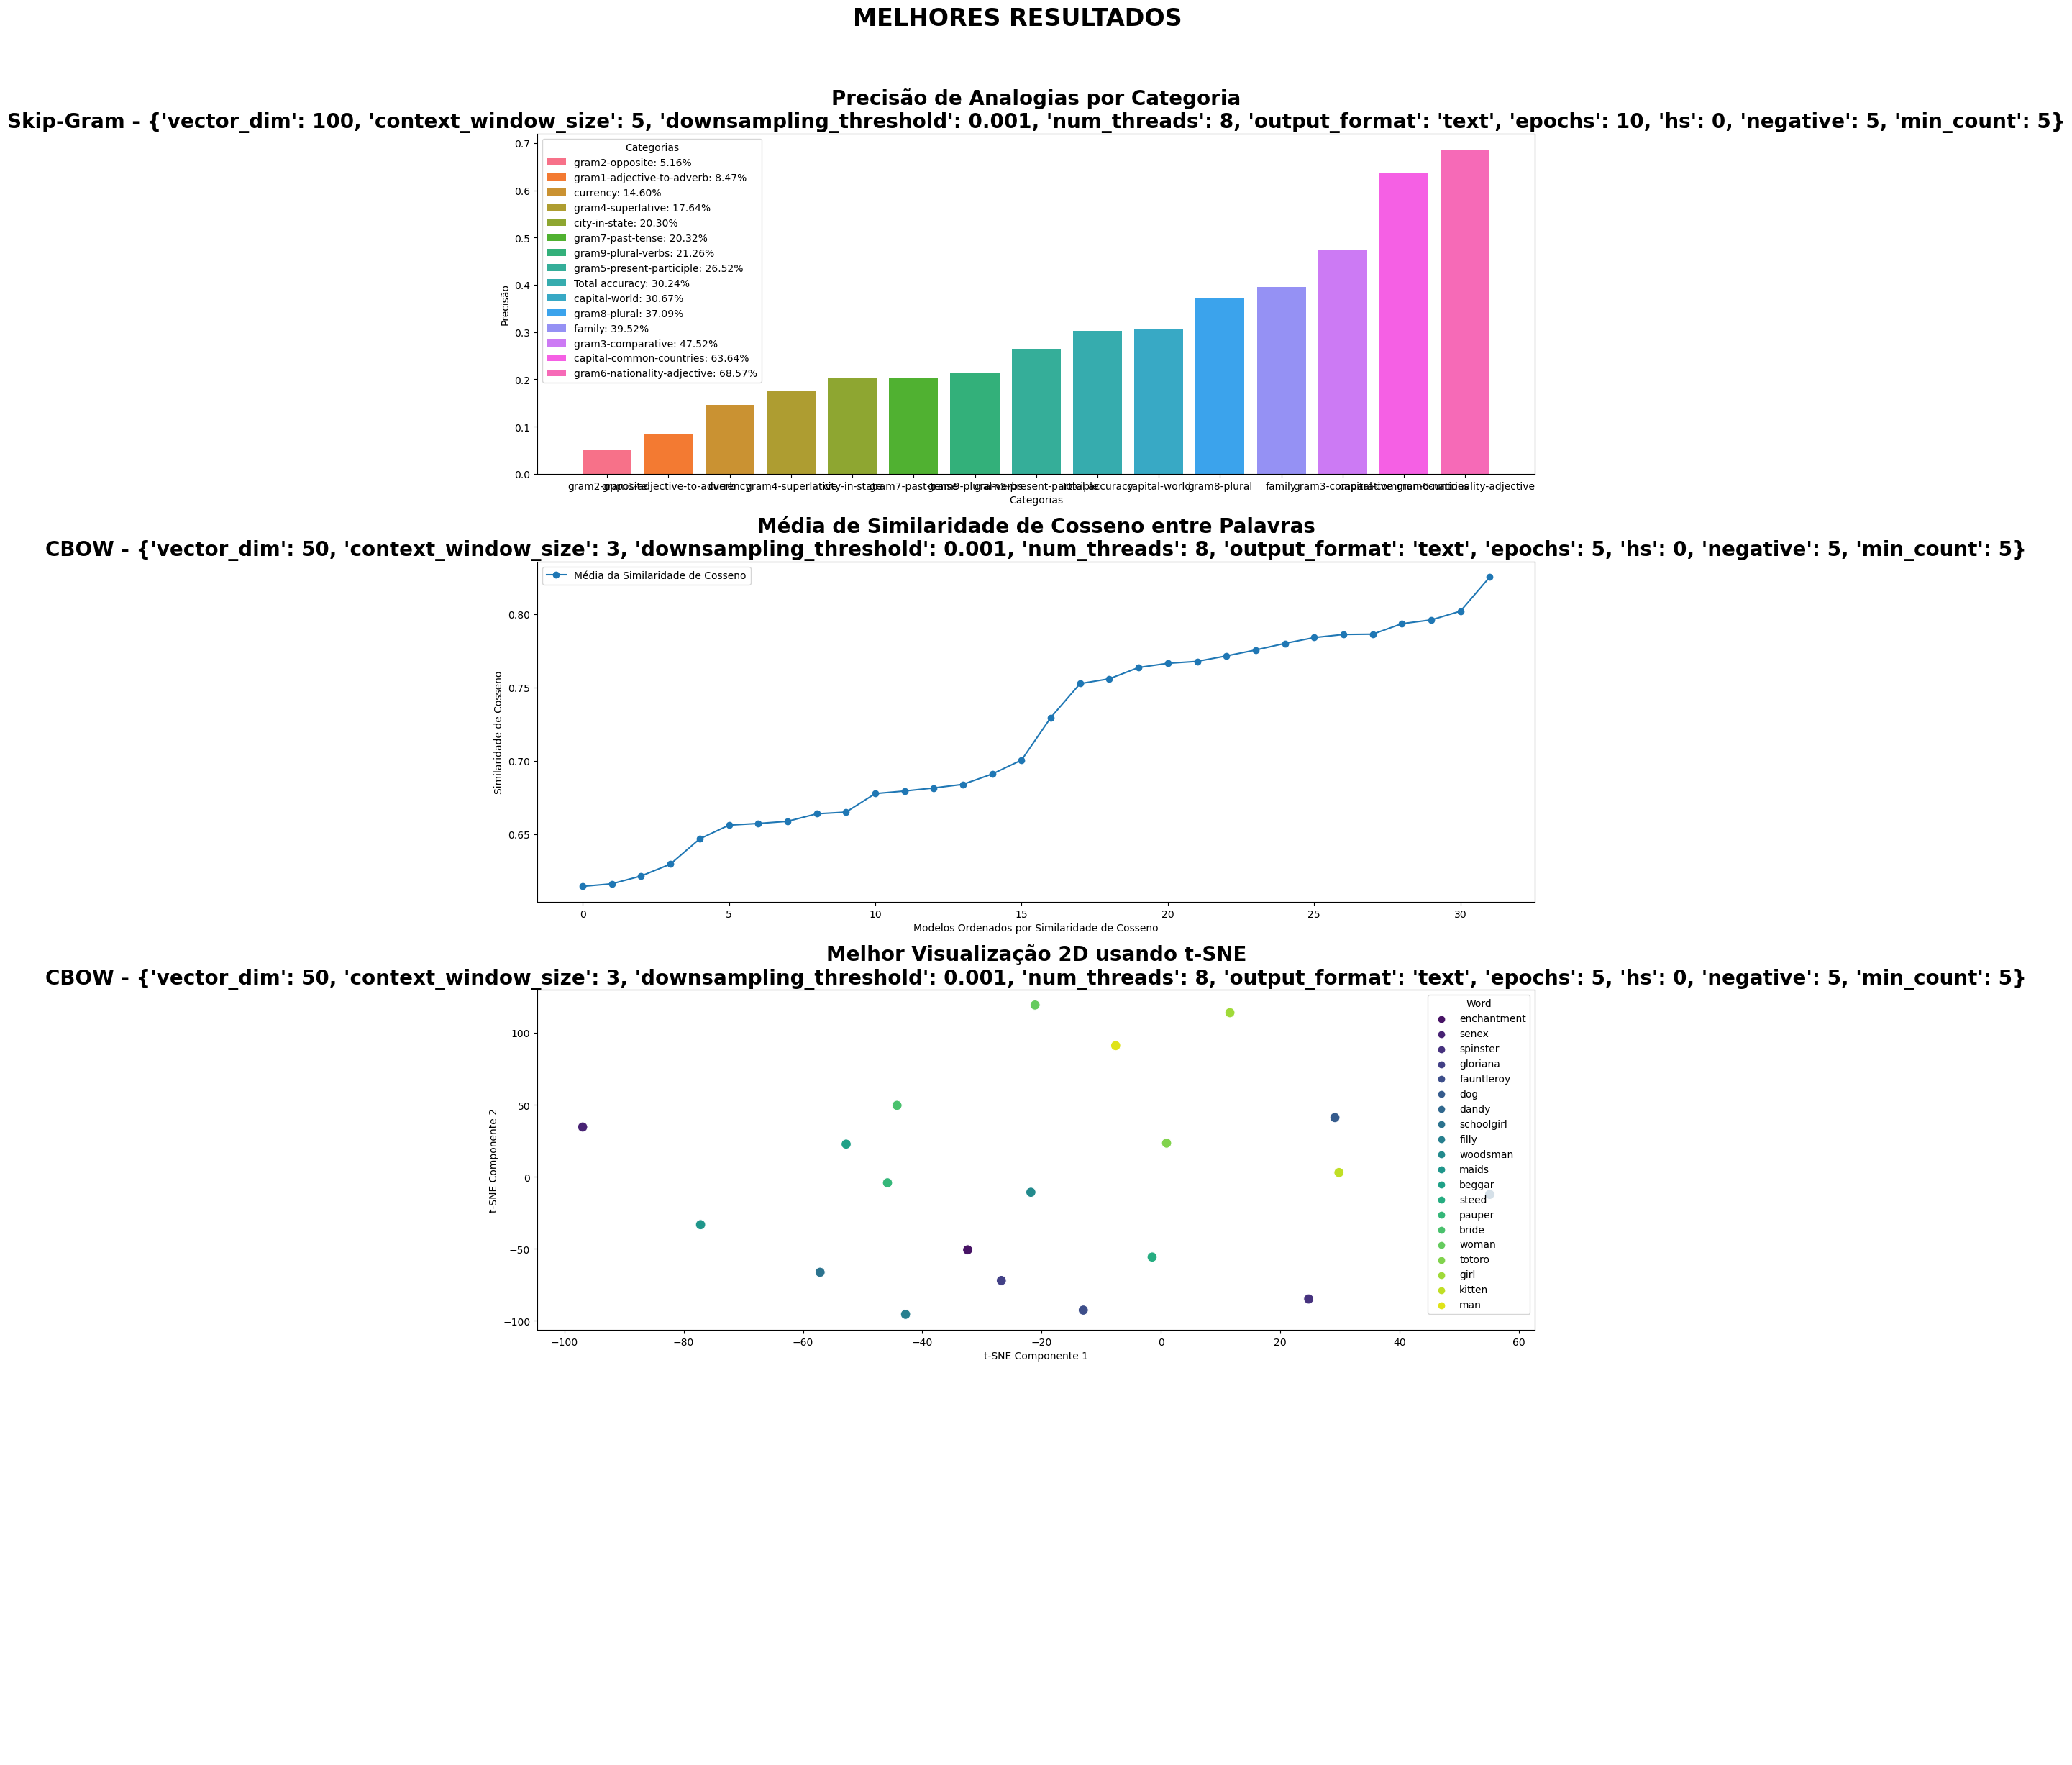

In [71]:
def display_best_results(results_list, model_names, param_sets):
    # Encontrar o índice do melhor resultado para cada métrica
    best_accuracy_index = max(range(len(results_list)), key=lambda i: results_list[i]['accuracy_section1'])
    best_precision_index = max(range(len(results_list)), key=lambda i: max(results_list[i]['category_accuracies'].values()))
    best_similarity_index = max(range(len(results_list)), key=lambda i: results_list[i]['average_cosine_similarity'])

    # Configuração da figura
    fig, axes = plt.subplots(4, 1, figsize=(15, 25))  # 4 linhas, 1 coluna

    # Título principal da figura
    fig.suptitle(f"MELHORES RESULTADOS", fontsize=24, fontweight='bold')

    # Obtenha as melhores tsne_df e parâmetros
    best_accuracy_tsne_df = results_list[best_accuracy_index]['tsne_df']
    best_precision_tsne_df = results_list[best_precision_index]['tsne_df']
    best_similarity_tsne_df = results_list[best_similarity_index]['tsne_df']

    best_accuracy_params = param_sets[best_accuracy_index]
    best_precision_params = param_sets[best_precision_index]
    best_similarity_params = param_sets[best_similarity_index]

    # Ajuste de tamanho de fonte para tabelas
    table_font_size = 12

    # Gráfico para Melhor Métrica 1: Precisão de Analogias por Categoria
    best_precision_values = results_list[best_precision_index]['category_accuracies']
    sorted_categories = sorted(best_precision_values, key=lambda x: best_precision_values[x])

    # Mapear cores para cada categoria
    category_colors = sns.color_palette('husl', n_colors=len(sorted_categories))

    bars = axes[0].bar(sorted_categories, [best_precision_values[cat] for cat in sorted_categories], color=category_colors, label='Precisão por Categoria')
    axes[0].set_title(f"Precisão de Analogias por Categoria\n{model_names[best_precision_index]} - {best_precision_params}", fontsize=20, fontweight='bold')
    axes[0].set_xlabel('Categorias')
    axes[0].set_ylabel('Precisão')

    # Adicionar legenda personalizada para as cores e categorias
    legend_labels = [f"{category}: {best_precision_values[category]:.2%}" for category in sorted_categories]
    axes[0].legend(handles=bars, title='Categorias', labels=legend_labels)

    # Gráfico para Melhor Métrica 2: Média da Similaridade de Cosseno entre Pares de Palavras
    all_cosine_similarities = [result['average_cosine_similarity'] for result in results_list]
    sorted_indices_similarity = np.argsort(all_cosine_similarities)
    sorted_cosine_similarities = [all_cosine_similarities[i] for i in sorted_indices_similarity]

    axes[1].plot(sorted_cosine_similarities, marker='o', label='Média da Similaridade de Cosseno')
    axes[1].set_title(f"Média de Similaridade de Cosseno entre Palavras\n{model_names[best_similarity_index]} - {best_similarity_params}", fontsize=20, fontweight='bold')
    axes[1].set_xlabel('Modelos Ordenados por Similaridade de Cosseno')
    axes[1].set_ylabel('Similaridade de Cosseno')
    axes[1].legend()

    # Calcular t-SNE para os melhores resultados
    tsne = TSNE(n_components=2, perplexity=10, random_state=42)
    tsne_result = tsne.fit_transform(best_similarity_tsne_df[['X', 'Y']])

    # Gráfico para Melhor Visualização 2D usando t-SNE
    sns.scatterplot(ax=axes[2], data=best_similarity_tsne_df, x='X', y='Y', hue='Word', s=100, legend='full', palette='viridis')
    axes[2].set_title(f"Melhor Visualização 2D usando t-SNE\n{model_names[best_similarity_index]} - {best_similarity_params}", fontsize=20, fontweight='bold')
    axes[2].set_xlabel('t-SNE Componente 1')
    axes[2].set_ylabel('t-SNE Componente 2')

    # Adicione um espaço em branco para evitar o gráfico vazio
    axes[3].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajuste da posição da suptitle
    plt.show()

display_best_results(all_evaluation_results, model_names, param_sets)

## Conclusão

A implementação e avaliação desses modelos Word2Vec fornecem uma compreensão mais profunda das capacidades de representação de palavras e das nuances entre os modelos Skip-Gram e CBOW. As análises detalhadas das métricas oferecem insights valiosos sobre o desempenho de cada modelo em tarefas específicas.